# Telco Customer Churn Challenge

- Useful resources:
  - `Theory.pdf`;
  - Central Limit Theorem Visualization: http://mfviz.com/central-limit/;
  - Bias-Variance Tradeoff: amount of error made given the true value;
  - Standard Deviation: https://en.wikipedia.org/wiki/Standard_deviation.

- Type of problem trees and forests can solve: Classification and Regression
- Goal: Predict whether a customer will churn.

## Imports and Constants

In [124]:
%reset -f

In [125]:
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # pip install xgboost
from sklearn.tree import plot_tree

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,confusion_matrix,classification_report,ConfusionMatrixDisplay, log_loss

## Get the data

In [126]:
df = pd.read_csv('https://raw.githubusercontent.com/SimeonHristov99/ML_23-24/main/DATA/Telco-Customer-Churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7028,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7029,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7030,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


## Exploratory Data Analysis

Check the types of the columns.

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


There are a lot of object columns and a few numeric columns.

See the statistics for the numeric features.

In [128]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


- The numeric features do not seem to be very skewed.
- The `SeniorCitizen` column has very low variance. Also, the min and max are 0 and 1 which suggest it might actually be a categorical feature.

See the statistics for the non-numeric features.

In [129]:
df.describe(include=object).T

,count,unique,top,freq
customerID,7032,7032,7590-VHVEG,1
gender,7032,2,Male,3549
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
MultipleLines,7032,3,No,3385
InternetService,7032,3,Fiber optic,3096
OnlineSecurity,7032,3,No,3497
OnlineBackup,7032,3,No,3087
DeviceProtection,7032,3,No,3094


- The `customerID` column is a unique identifier which we can ignore.
- The cardinality of most of the object columns is low.
- Half of the customers are male, have a fiber optic connection, have a month-to-month contract.
- We have an imbalanced dataset. Most of the customers do not churn.

In [130]:
df.isna().mean()

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

There are no missing values.

Check the distribution of the target variable.

In [131]:
df['Churn'].value_counts(dropna=False)

Churn
No     5163
Yes    1869
Name: count, dtype: int64

We have an imbalanced dataset. Most of the customers do not churn.

See the unique values.

In [132]:
for col in df:
  unq_vals = df[col].unique()
  num_unq_vals = len(unq_vals)
  
  if num_unq_vals < 12:
    print(f'Unique {col:17} | {df[col].dtype} | {num_unq_vals:5} | {unq_vals}')
  else:
    print(f'Unique {col:17} | {df[col].dtype} | {num_unq_vals:5} |')

Unique customerID        | object |  7032 |
Unique gender            | object |     2 | ['Female' 'Male']
Unique SeniorCitizen     | int64 |     2 | [0 1]
Unique Partner           | object |     2 | ['Yes' 'No']
Unique Dependents        | object |     2 | ['No' 'Yes']
Unique tenure            | int64 |    72 |
Unique PhoneService      | object |     2 | ['No' 'Yes']
Unique MultipleLines     | object |     3 | ['No phone service' 'No' 'Yes']
Unique InternetService   | object |     3 | ['DSL' 'Fiber optic' 'No']
Unique OnlineSecurity    | object |     3 | ['No' 'Yes' 'No internet service']
Unique OnlineBackup      | object |     3 | ['Yes' 'No' 'No internet service']
Unique DeviceProtection  | object |     3 | ['No' 'Yes' 'No internet service']
Unique TechSupport       | object |     3 | ['No' 'Yes' 'No internet service']
Unique StreamingTV       | object |     3 | ['No' 'Yes' 'No internet service']
Unique StreamingMovies   | object |     3 | ['No' 'Yes' 'No internet service']
Unique Con

- `tenure` has relatively low cardinality given that it's a numeric feature. According to the description, tenure is the number of months the customer has stayed with the company.
- The `SeniorCitizen` column should be regarded as a categorical feature.
- The `Contract` column could be regarded as an ordinal feature.
- The `TotalCharges` column has be regarded as a numeric feature.

Plot the distribution of the `TotalCharges` column.

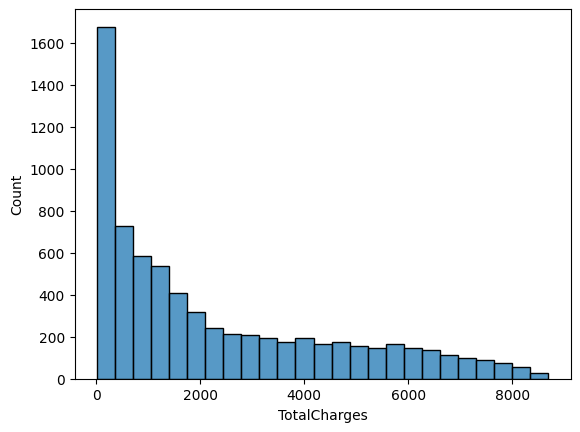

In [133]:
ax = sns.histplot(df['TotalCharges'].astype(float))

Show relationships between numeric features and the target column.

Create a table of the proper numeric features.

In [134]:
tmp_numeric_feats = pd.concat([df.select_dtypes('number').drop(['SeniorCitizen'], axis=1), df['Churn']], axis=1)
tmp_numeric_feats

,tenure,MonthlyCharges,TotalCharges,Churn
0,1,29.85,29.85,No
1,34,56.95,1889.50,No
2,2,53.85,108.15,Yes
3,45,42.30,1840.75,No
4,2,70.70,151.65,Yes
...,...,...,...,...
7027,24,84.80,1990.50,No
7028,72,103.20,7362.90,No
7029,11,29.60,346.45,No
7030,4,74.40,306.60,Yes


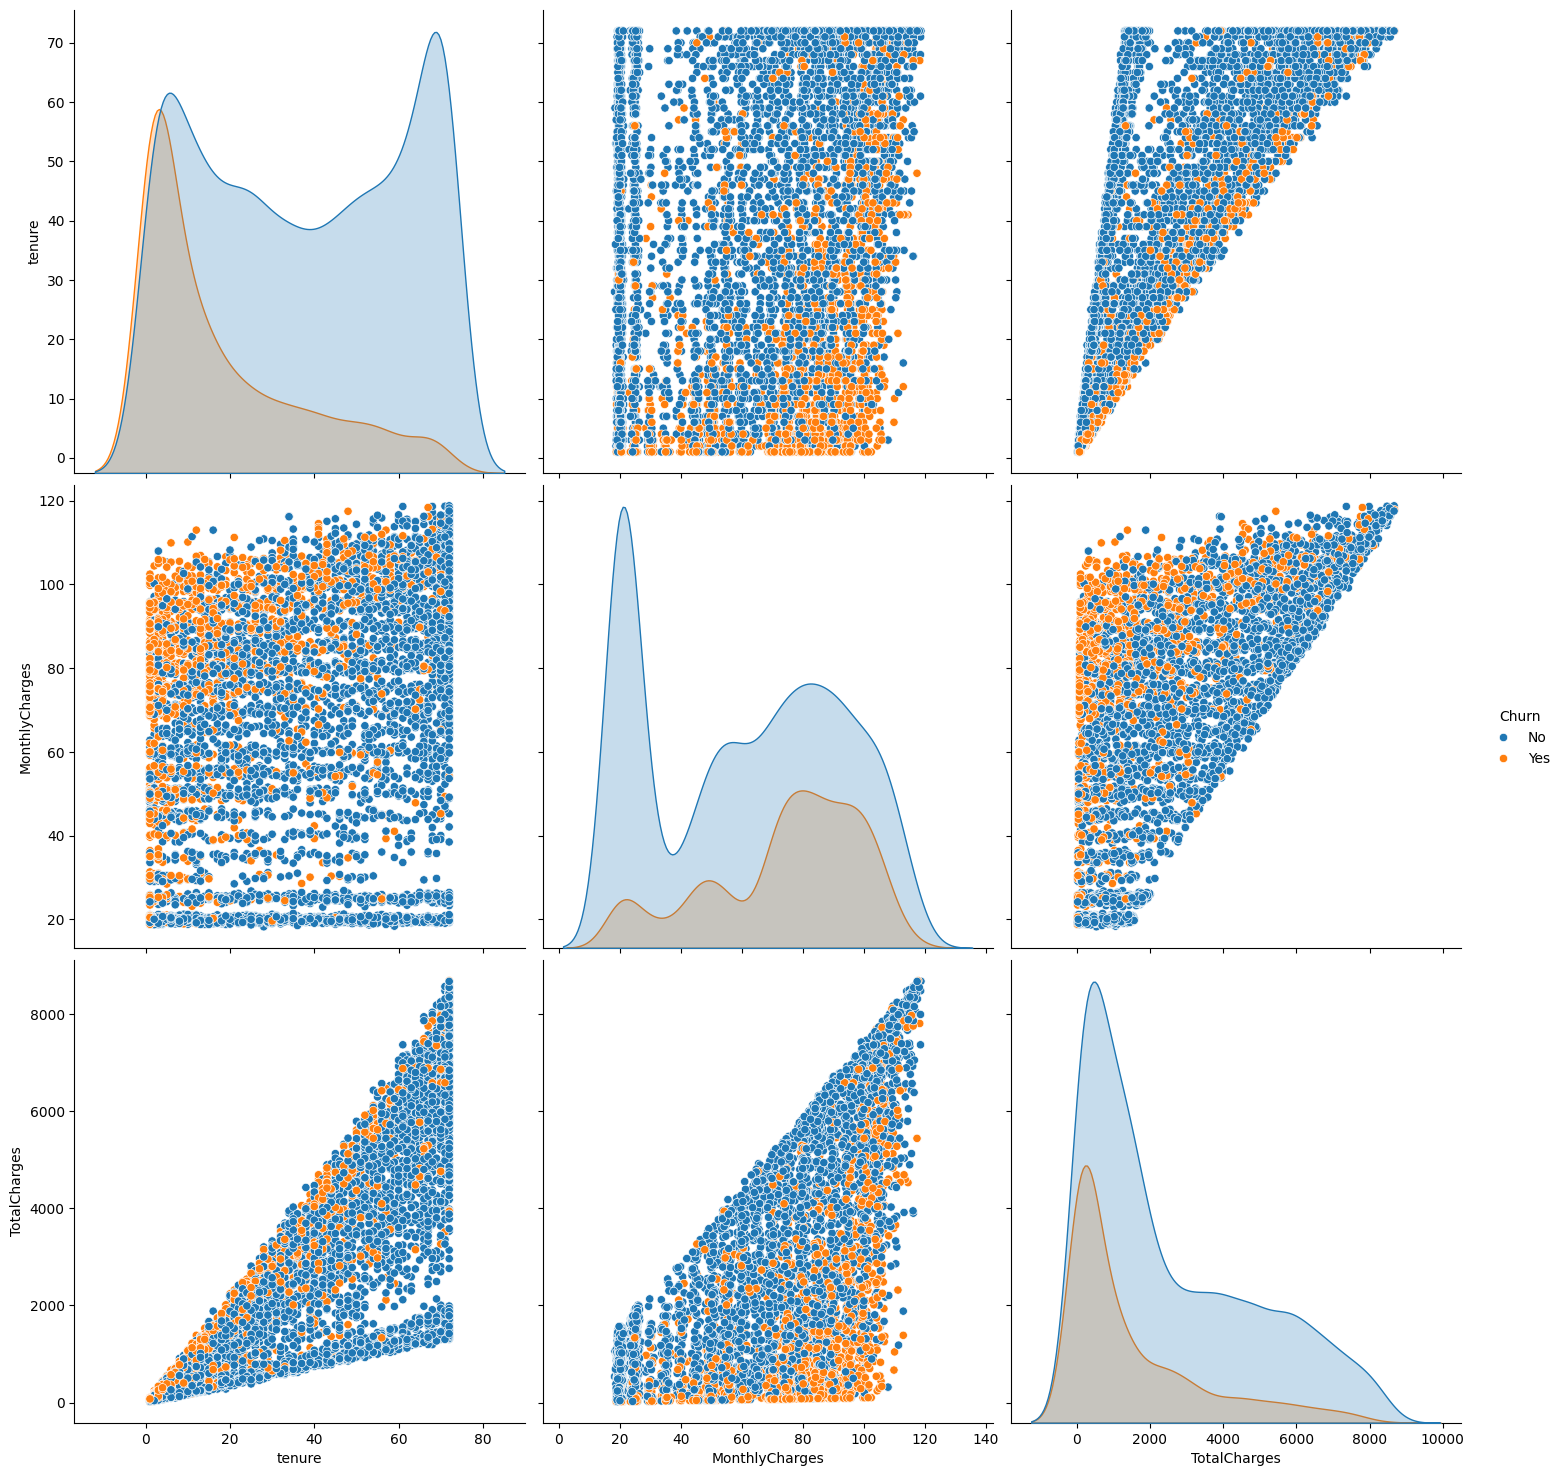

In [135]:
ax = sns.pairplot(tmp_numeric_feats, hue='Churn', height=5)

- `tenure` has a bimodal distribution
- the longer a customer has stayed with the company the less likely they are to churn
- for monthly charges below 40 there is little change that the customer will churn
- the customers who churn generally have low `TotalCharges` but have high `MonthlyCharges`
- customers who have been for long with the company and pay low `TotalCharges` almost never churn

Show relationships between categorical features and the target column.

In [136]:
cat_features = df.select_dtypes('object').columns.drop(['customerID', 'Churn'])
cat_features

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

C:\Users\c86608b\AppData\Local\Temp\1\ipykernel_3984\3002306300.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\c86608b\AppData\Local\Temp\1\ipykernel_3984\3002306300.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\c86608b\AppData\Local\Temp\1\ipykernel_3984\3002306300.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\c86608b\AppData\Local\Temp\1\ipykernel_3984\3002306300.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\c86608b\AppData\Local\Temp\1\ipykernel_3984\3002306300.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\c86608b\AppData\Local\Temp\1\ipykernel_3984\3002306300.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\c86608b\AppData\Local\Temp\1\ipykernel_3984\30023

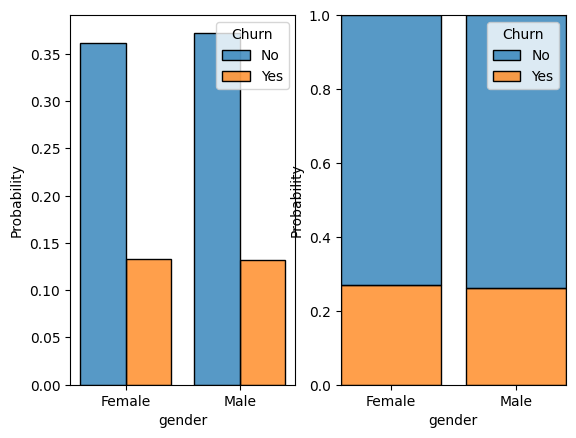

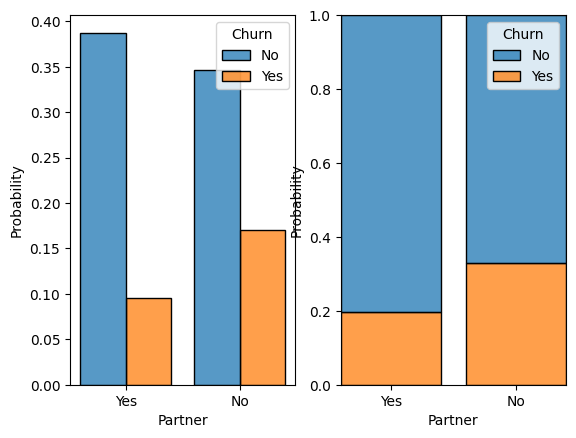

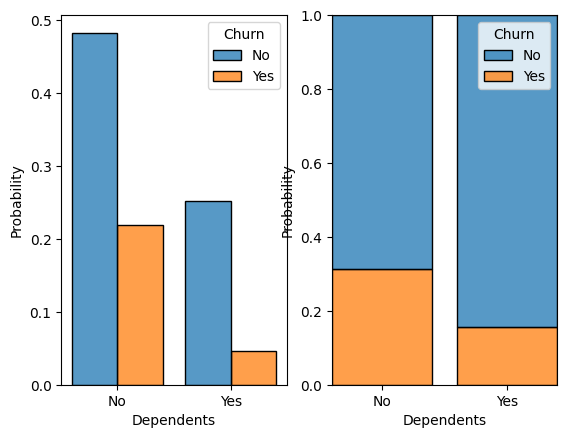

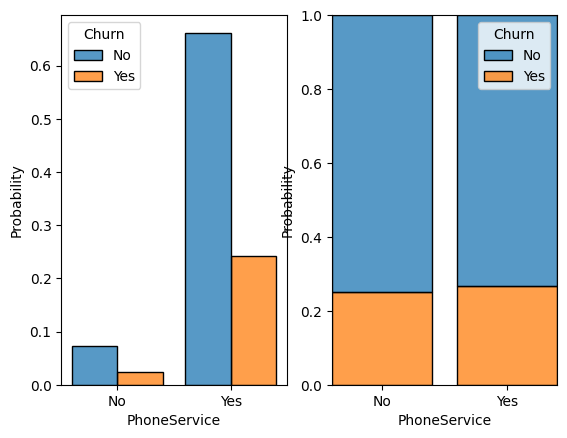

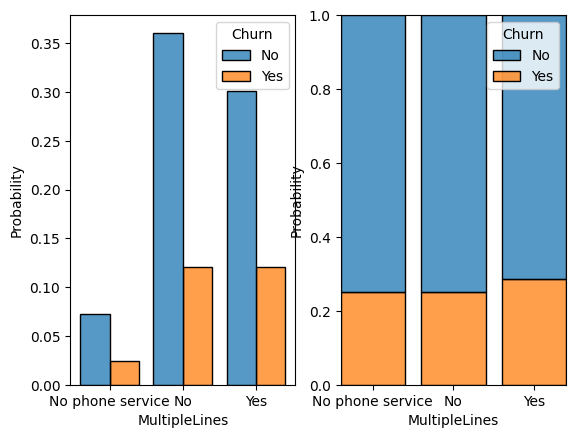

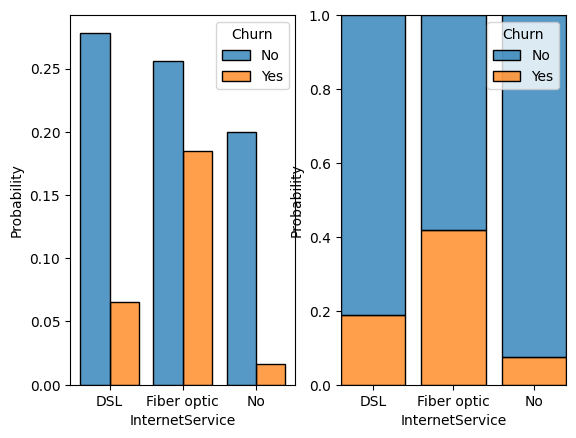

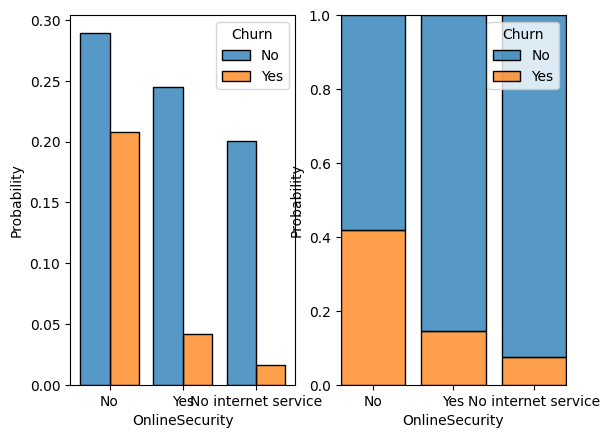

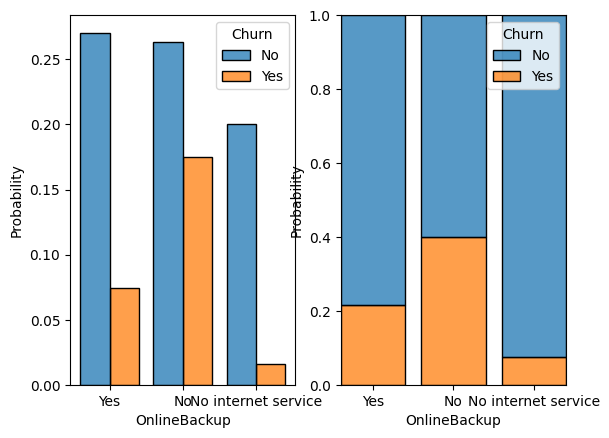

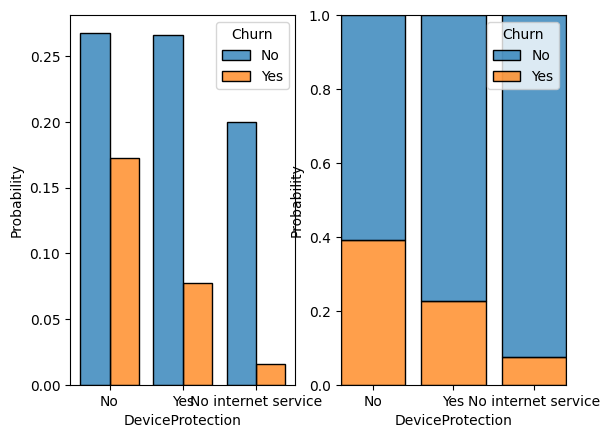

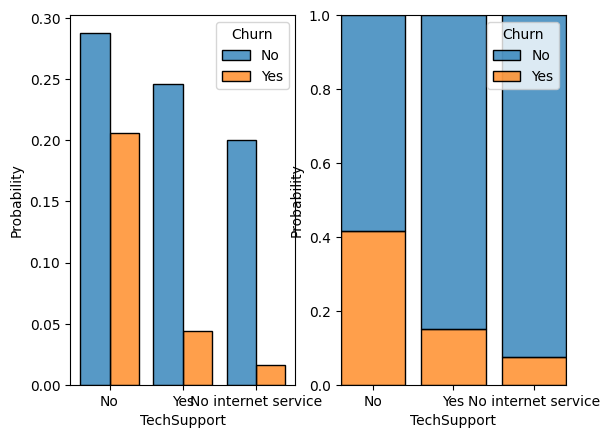

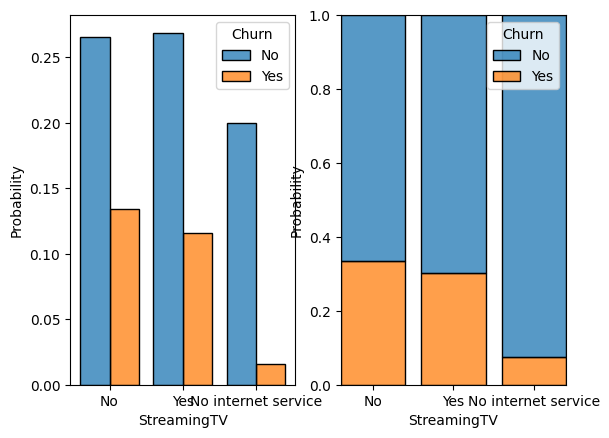

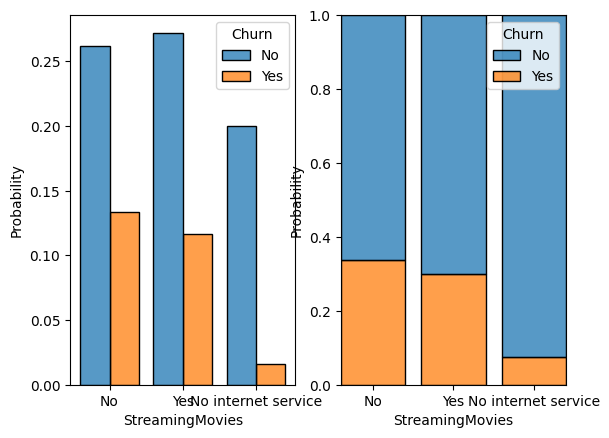

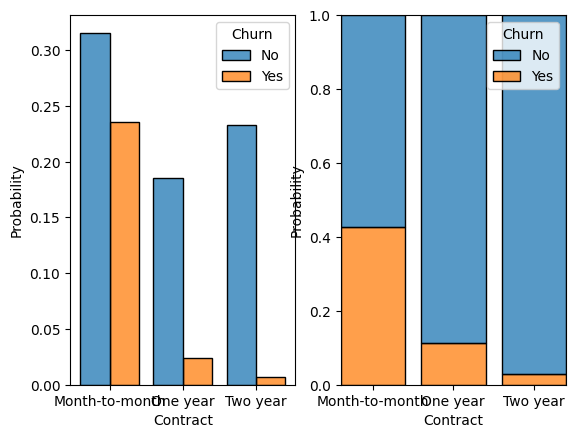

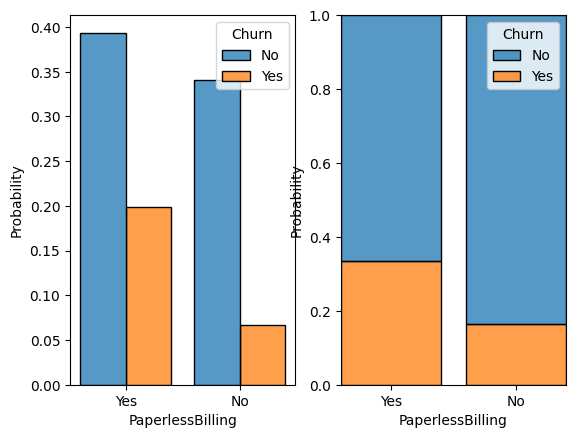

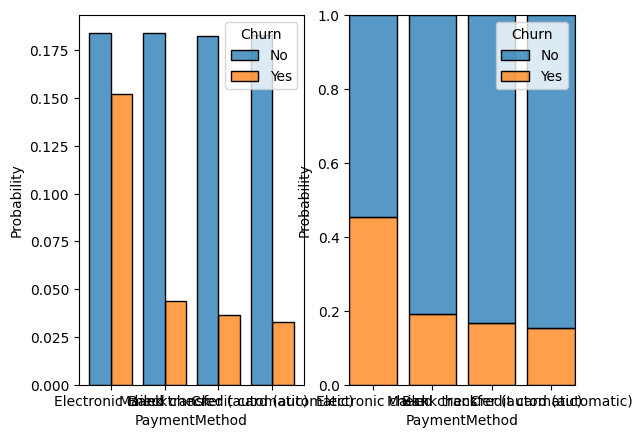

In [137]:
for col in cat_features:
  fig, ax = plt.subplots(1,2)
  ax1 = sns.histplot(data=df, x=col, hue="Churn", stat="probability", multiple="dodge", shrink=.8, ax=ax[0])
  ax2 = sns.histplot(data=df, x=col, hue="Churn", stat="probability", multiple="fill", shrink=.8, ax=ax[1])
  fig.show()

- no link between churn and gender
- customers without dependents less likely to churn
- customers with fiber optic more likely to churn
- in general customers without internet service less likely to churn
- customers without online security more likely to churn
- customers with online backup more likely to churn
- customers without device protection more likely to churn
- customers without technical support more likely to churn
- customers with one year or two year contrancts less likely to churn
- customers with electronic check more likely to churn

## Preprocessing

<img src='https://raw.githubusercontent.com/SimeonHristov99/ML_23-24/main/assets/ohe.png'>

In [138]:
def preprocess_inputs(df, return_X_y=False):
  df = df.copy()

  # Drop columns that give little information
  df = df.drop(['customerID'], axis=1)

  # Transform categorical features into numeric
  df['TotalCharges'] = df['TotalCharges'].replace(' ', np.NaN)
  df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mode()[0]).astype(float)

  # One-hot encode binary categorical features
  for col in ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']:
    dummies = pd.get_dummies(df[col], prefix=col).iloc[:, 0]
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(col, axis=1)
  
  # One-hot encode binary categorical features
  for col in ['MultipleLines', 	'InternetService', 	'OnlineSecurity', 	'OnlineBackup', 	'DeviceProtection', 	'TechSupport', 	'StreamingTV', 	'StreamingMovies', 	'Contract', 	'PaymentMethod']:
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(col, axis=1)
  
  # Split into X and y
  y = df['Churn']
  X = df.drop(['Churn'], axis=1)

  if return_X_y:
    return X, y

  # Label-encode the target column for easier interpretation
  y = y.map({'Yes': 1, 'No': 0})

  # Train test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
  
  return X_train, X_test, y_train, y_test

In [139]:
X_train, X_test, y_train, y_test = preprocess_inputs(df)
X_train

,tenure,MonthlyCharges,TotalCharges,gender_Female,SeniorCitizen_0,Partner_No,Dependents_No,PhoneService_No,PaperlessBilling_No,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2351,46,45.20,2065.15,False,True,True,True,False,False,True,...,True,False,False,True,False,False,False,True,False,False
4025,68,84.65,5683.60,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4354,29,58.75,1696.20,False,True,True,True,False,False,True,...,True,False,False,False,True,False,False,False,True,False
5240,72,67.20,4671.70,False,True,True,False,True,True,False,...,False,False,True,False,False,True,False,True,False,False
4019,72,114.30,8058.55,False,True,False,False,False,False,False,...,False,False,True,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,34,24.70,780.20,True,True,False,True,False,True,False,...,False,True,False,True,False,False,False,False,True,False
123,7,50.70,350.35,True,True,False,False,False,True,True,...,True,False,False,True,False,False,False,False,False,True
1321,1,69.25,69.25,True,False,True,True,False,False,True,...,True,False,False,True,False,False,False,False,True,False
2538,13,98.15,1230.25,False,True,True,True,False,True,False,...,False,False,True,True,False,False,False,False,False,True


In [140]:
y_train

2351    0
4025    0
4354    0
5240    0
4019    0
       ..
175     0
123     0
1321    1
2538    1
3465    0
Name: Churn, Length: 4922, dtype: int64

## Model building

In [141]:
df_results = pd.DataFrame(
    columns=['experiment', 'accuracy', 'precision', 'recall', 'f1-score']
)
df_results

,experiment,accuracy,precision,recall,f1-score


### Decision Tree

In [142]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
df_results = pd.concat([df_results, pd.DataFrame({
    'experiment': ['decision_tree_default_args'],
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1-score': [f1_score(y_test, y_pred)],
    'log_loss': [log_loss(y_test, y_pred)]
})], ignore_index=True)
df_results

C:\Users\c86608b\AppData\Local\Temp\1\ipykernel_3984\146028450.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame({


,experiment,accuracy,precision,recall,f1-score,log_loss
0,decision_tree_default_args,0.700948,0.456559,0.462069,0.459297,10.778931


In [143]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
df_results = pd.concat([df_results, pd.DataFrame({
    'experiment': ['decision_tree_max_depth_3'],
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1-score': [f1_score(y_test, y_pred)],
    'log_loss': [log_loss(y_test, y_pred)]
})], ignore_index=True)
df_results

,experiment,accuracy,precision,recall,f1-score,log_loss
0,decision_tree_default_args,0.700948,0.456559,0.462069,0.459297,10.778931
1,decision_tree_max_depth_3,0.786730,0.718121,0.368966,0.487472,7.687035


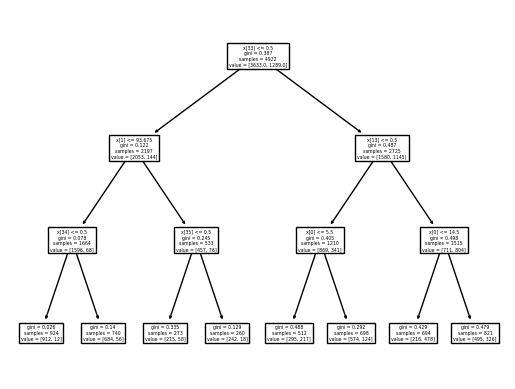

In [144]:
ax = plot_tree(dt)

In [145]:
dt = DecisionTreeClassifier(max_depth=3, criterion='entropy')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
df_results = pd.concat([df_results, pd.DataFrame({
    'experiment': ['decision_tree_max_depth_3_entropy'],
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1-score': [f1_score(y_test, y_pred)],
    'log_loss': [log_loss(y_test, y_pred)]
})], ignore_index=True)
df_results

,experiment,accuracy,precision,recall,f1-score,log_loss
0,decision_tree_default_args,0.700948,0.456559,0.462069,0.459297,10.778931
1,decision_tree_max_depth_3,0.786730,0.718121,0.368966,0.487472,7.687035
2,decision_tree_max_depth_3_entropy,0.786730,0.718121,0.368966,0.487472,7.687035


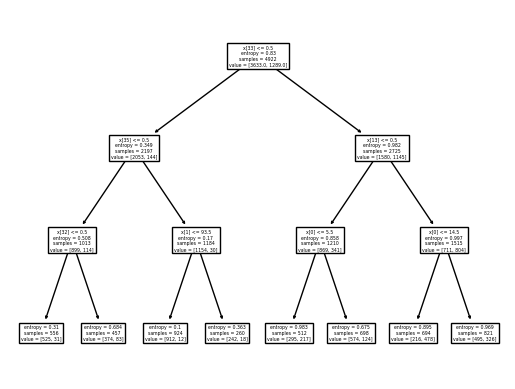

In [146]:
ax = plot_tree(dt)

In [147]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
df_results = pd.concat([df_results, pd.DataFrame({
    'experiment': ['decision_tree_max_depth_4_min_samples_leaft_1'],
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1-score': [f1_score(y_test, y_pred)],
    'log_loss': [log_loss(y_test, y_pred)]
})], ignore_index=True)
df_results

,experiment,accuracy,precision,recall,f1-score,log_loss
0,decision_tree_default_args,0.700948,0.456559,0.462069,0.459297,10.778931
1,decision_tree_max_depth_3,0.786730,0.718121,0.368966,0.487472,7.687035
2,decision_tree_max_depth_3_entropy,0.786730,0.718121,0.368966,0.487472,7.687035
3,decision_tree_max_depth_4_min_samples_leaft_1,0.777725,0.624719,0.479310,0.542439,8.011599


In [148]:
df = pd.DataFrame()
df['column'] = X_train.columns
df['importance'] = dt.feature_importances_
df = df.sort_values(by='importance', ascending=False)
df

,column,importance
33,Contract_Month-to-month,0.541050
0,tenure,0.176474
13,InternetService_Fiber optic,0.147367
14,InternetService_No,0.037694
1,MonthlyCharges,0.022270
38,PaymentMethod_Electronic check,0.021505
2,TotalCharges,0.021113
7,PhoneService_No,0.013917
34,Contract_One year,0.009662
35,Contract_Two year,0.005711


<Axes: title={'center': 'Ten most important features'}, xlabel='importance', ylabel='column'>

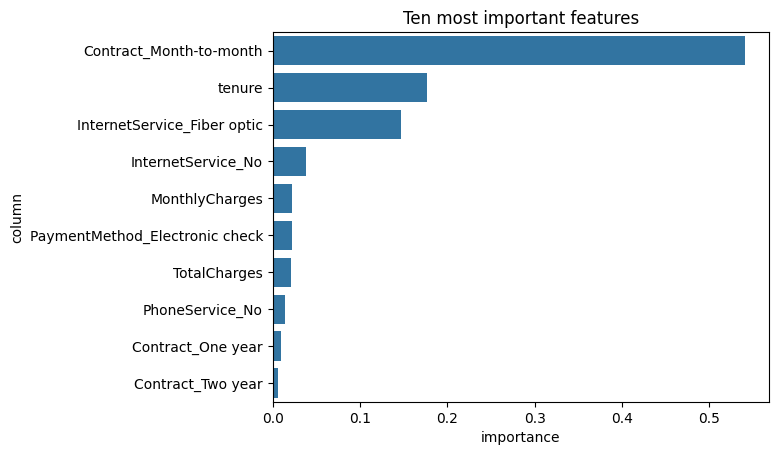

In [149]:
plt.title('Ten most important features')
sns.barplot(x='importance', y='column', data=df.iloc[:10], orient='h')

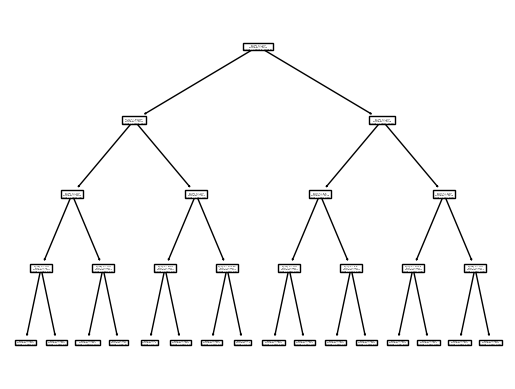

In [150]:
ax = plot_tree(dt)

See which feature is most important in determining whether a customer will churn.

Let's check the confusion matrix.

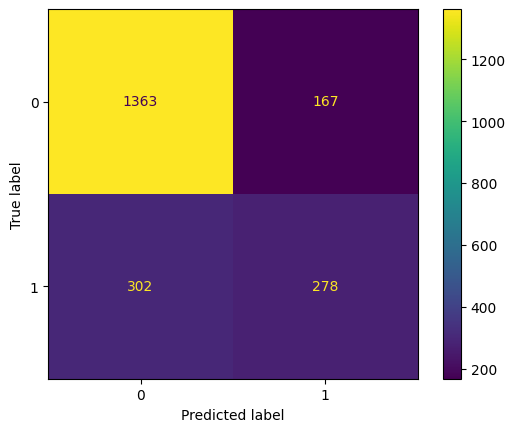

In [151]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [152]:
dt = DecisionTreeClassifier(max_depth=7, min_samples_leaf=3)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
df_results = pd.concat([df_results, pd.DataFrame({
    'experiment': ['decision_tree_max_depth_7_min_samples_leaft_3'],
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1-score': [f1_score(y_test, y_pred)],
    'log_loss': [log_loss(y_test, y_pred)]
})], ignore_index=True)
df_results

,experiment,accuracy,precision,recall,f1-score,log_loss
0,decision_tree_default_args,0.700948,0.456559,0.462069,0.459297,10.778931
1,decision_tree_max_depth_3,0.786730,0.718121,0.368966,0.487472,7.687035
2,decision_tree_max_depth_3_entropy,0.786730,0.718121,0.368966,0.487472,7.687035
3,decision_tree_max_depth_4_min_samples_leaft_1,0.777725,0.624719,0.479310,0.542439,8.011599
4,decision_tree_max_depth_7_min_samples_leaft_3,0.783886,0.628099,0.524138,0.571429,7.789529


## Model building. Random forest

In [153]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = dt.predict(X_test)
df_results = pd.concat([df_results, pd.DataFrame({
    'experiment': ['random_forest_n_estimators_100'],
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1-score': [f1_score(y_test, y_pred)],
    'log_loss': [log_loss(y_test, y_pred)]
})], ignore_index=True)
df_results

,experiment,accuracy,precision,recall,f1-score,log_loss
0,decision_tree_default_args,0.700948,0.456559,0.462069,0.459297,10.778931
1,decision_tree_max_depth_3,0.786730,0.718121,0.368966,0.487472,7.687035
2,decision_tree_max_depth_3_entropy,0.786730,0.718121,0.368966,0.487472,7.687035
3,decision_tree_max_depth_4_min_samples_leaft_1,0.777725,0.624719,0.479310,0.542439,8.011599
4,decision_tree_max_depth_7_min_samples_leaft_3,0.783886,0.628099,0.524138,0.571429,7.789529
5,random_forest_n_estimators_100,0.783886,0.628099,0.524138,0.571429,7.789529


In [154]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
df_results = pd.concat([df_results, pd.DataFrame({
    'experiment': ['random_forest_n_estimators_50'],
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1-score': [f1_score(y_test, y_pred)],
    'log_loss': [log_loss(y_test, y_pred)]
})], ignore_index=True)
df_results

,experiment,accuracy,precision,recall,f1-score,log_loss
0,decision_tree_default_args,0.700948,0.456559,0.462069,0.459297,10.778931
1,decision_tree_max_depth_3,0.786730,0.718121,0.368966,0.487472,7.687035
2,decision_tree_max_depth_3_entropy,0.786730,0.718121,0.368966,0.487472,7.687035
3,decision_tree_max_depth_4_min_samples_leaft_1,0.777725,0.624719,0.479310,0.542439,8.011599
4,decision_tree_max_depth_7_min_samples_leaft_3,0.783886,0.628099,0.524138,0.571429,7.789529
5,random_forest_n_estimators_100,0.783886,0.628099,0.524138,0.571429,7.789529
6,random_forest_n_estimators_50,0.783886,0.649758,0.463793,0.541247,7.789529


In [155]:
rf = RandomForestClassifier(n_estimators=150)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
df_results = pd.concat([df_results, pd.DataFrame({
    'experiment': ['random_forest_n_estimators_150'],
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1-score': [f1_score(y_test, y_pred)],
    'log_loss': [log_loss(y_test, y_pred)]
})], ignore_index=True)
df_results

,experiment,accuracy,precision,recall,f1-score,log_loss
0,decision_tree_default_args,0.700948,0.456559,0.462069,0.459297,10.778931
1,decision_tree_max_depth_3,0.786730,0.718121,0.368966,0.487472,7.687035
2,decision_tree_max_depth_3_entropy,0.786730,0.718121,0.368966,0.487472,7.687035
3,decision_tree_max_depth_4_min_samples_leaft_1,0.777725,0.624719,0.479310,0.542439,8.011599
4,decision_tree_max_depth_7_min_samples_leaft_3,0.783886,0.628099,0.524138,0.571429,7.789529
5,random_forest_n_estimators_100,0.783886,0.628099,0.524138,0.571429,7.789529
6,random_forest_n_estimators_50,0.783886,0.649758,0.463793,0.541247,7.789529
7,random_forest_n_estimators_150,0.782464,0.647202,0.458621,0.536831,7.840776


In [156]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
df_results = pd.concat([df_results, pd.DataFrame({
    'experiment': ['random_forest_n_estimators_100_criterion_entropy'],
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1-score': [f1_score(y_test, y_pred)],
    'log_loss': [log_loss(y_test, y_pred)]
})], ignore_index=True)
df_results

,experiment,accuracy,precision,recall,f1-score,log_loss
0,decision_tree_default_args,0.700948,0.456559,0.462069,0.459297,10.778931
1,decision_tree_max_depth_3,0.786730,0.718121,0.368966,0.487472,7.687035
2,decision_tree_max_depth_3_entropy,0.786730,0.718121,0.368966,0.487472,7.687035
3,decision_tree_max_depth_4_min_samples_leaft_1,0.777725,0.624719,0.479310,0.542439,8.011599
4,decision_tree_max_depth_7_min_samples_leaft_3,0.783886,0.628099,0.524138,0.571429,7.789529
5,random_forest_n_estimators_100,0.783886,0.628099,0.524138,0.571429,7.789529
6,random_forest_n_estimators_50,0.783886,0.649758,0.463793,0.541247,7.789529
7,random_forest_n_estimators_150,0.782464,0.647202,0.458621,0.536831,7.840776
8,random_forest_n_estimators_100_criterion_entropy,0.781991,0.642180,0.467241,0.540918,7.857858


### Hyperparameter tuning via Grid Search

In [162]:
criterions = ['gini', 'entropy']
n_estimators = [10, 50, 100, 150, 200]
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5, 10, 20]

scores = {}

for n, f, d, c in product(n_estimators, max_features, max_depths, criterions):
  rf = RandomForestClassifier(n_estimators=n, criterion=c, max_features=f, max_depth=d, n_jobs=-1)
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)
  f1 = f1_score(y_test, y_pred)
  scores[(n, f, d, c)] = f1
  print(f'f1 for {n, f, d, c}: {f1:.2f}')

best_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
best_scores

f1 for (10, 1, None, 'gini'): 0.48
f1 for (10, 1, None, 'entropy'): 0.50
f1 for (10, 1, 2, 'gini'): 0.00
f1 for (10, 1, 2, 'entropy'): 0.00
f1 for (10, 1, 3, 'gini'): 0.05
f1 for (10, 1, 3, 'entropy'): 0.00
f1 for (10, 1, 4, 'gini'): 0.15
f1 for (10, 1, 4, 'entropy'): 0.00
f1 for (10, 1, 5, 'gini'): 0.26
f1 for (10, 1, 5, 'entropy'): 0.30
f1 for (10, 1, 10, 'gini'): 0.55
f1 for (10, 1, 10, 'entropy'): 0.57
f1 for (10, 1, 20, 'gini'): 0.50
f1 for (10, 1, 20, 'entropy'): 0.49
f1 for (10, 'sqrt', None, 'gini'): 0.50
f1 for (10, 'sqrt', None, 'entropy'): 0.51
f1 for (10, 'sqrt', 2, 'gini'): 0.06
f1 for (10, 'sqrt', 2, 'entropy'): 0.32
f1 for (10, 'sqrt', 3, 'gini'): 0.43
f1 for (10, 'sqrt', 3, 'entropy'): 0.52
f1 for (10, 'sqrt', 4, 'gini'): 0.51
f1 for (10, 'sqrt', 4, 'entropy'): 0.55
f1 for (10, 'sqrt', 5, 'gini'): 0.54
f1 for (10, 'sqrt', 5, 'entropy'): 0.50
f1 for (10, 'sqrt', 10, 'gini'): 0.56
f1 for (10, 'sqrt', 10, 'entropy'): 0.58
f1 for (10, 'sqrt', 20, 'gini'): 0.53
f1 for (10, '

[((200, 'log2', 10, 'gini'), 0.5780933062880325),
 ((100, 'sqrt', 10, 'entropy'), 0.5771543086172345),
 ((50, 'sqrt', 10, 'gini'), 0.5763052208835341),
 ((100, 'log2', 10, 'entropy'), 0.5763052208835341),
 ((200, 'sqrt', 10, 'gini'), 0.576),
 ((100, 'sqrt', 10, 'gini'), 0.5757575757575758),
 ((10, 'sqrt', 10, 'entropy'), 0.575098814229249),
 ((150, 'sqrt', 10, 'entropy'), 0.5711382113821138),
 ((50, 'log2', 10, 'entropy'), 0.570281124497992),
 ((100, 'log2', 10, 'gini'), 0.5688259109311741),
 ((150, 'sqrt', 10, 'gini'), 0.5685279187817259),
 ((10, 1, 10, 'entropy'), 0.5658835546475995),
 ((150, 'log2', 10, 'entropy'), 0.5650406504065041),
 ((10, 'log2', 10, 'entropy'), 0.5647058823529412),
 ((10, 'log2', 10, 'gini'), 0.5636363636363636),
 ((150, 'log2', 10, 'gini'), 0.5636363636363636),
 ((200, 'log2', 10, 'entropy'), 0.5621840242669363),
 ((10, 'sqrt', 10, 'gini'), 0.5621301775147929),
 ((50, 'log2', 10, 'gini'), 0.5607287449392713),
 ((200, 'sqrt', 10, 'entropy'), 0.560081466395112),

In [163]:
best_scores

[((200, 'log2', 10, 'gini'), 0.5780933062880325),
 ((100, 'sqrt', 10, 'entropy'), 0.5771543086172345),
 ((50, 'sqrt', 10, 'gini'), 0.5763052208835341),
 ((100, 'log2', 10, 'entropy'), 0.5763052208835341),
 ((200, 'sqrt', 10, 'gini'), 0.576),
 ((100, 'sqrt', 10, 'gini'), 0.5757575757575758),
 ((10, 'sqrt', 10, 'entropy'), 0.575098814229249),
 ((150, 'sqrt', 10, 'entropy'), 0.5711382113821138),
 ((50, 'log2', 10, 'entropy'), 0.570281124497992),
 ((100, 'log2', 10, 'gini'), 0.5688259109311741),
 ((150, 'sqrt', 10, 'gini'), 0.5685279187817259),
 ((10, 1, 10, 'entropy'), 0.5658835546475995),
 ((150, 'log2', 10, 'entropy'), 0.5650406504065041),
 ((10, 'log2', 10, 'entropy'), 0.5647058823529412),
 ((10, 'log2', 10, 'gini'), 0.5636363636363636),
 ((150, 'log2', 10, 'gini'), 0.5636363636363636),
 ((200, 'log2', 10, 'entropy'), 0.5621840242669363),
 ((10, 'sqrt', 10, 'gini'), 0.5621301775147929),
 ((50, 'log2', 10, 'gini'), 0.5607287449392713),
 ((200, 'sqrt', 10, 'entropy'), 0.560081466395112),

The f1 score is still low. We cannot say that random forest did better than 1 decision tree.

What we got in class:
- n_estimator = 200
- max_feature = 'log2'
- max_depth = 10
- criterion = 'gini'

and it achieves an f1 score of 0.58.